## 재정정보 AI 검색 알고리즘 경진대회 코드
대회 주소 : https://dacon.io/competitions/official/236295/overview/description
### 시스템 환경
OS : Docker - pytorch/pytorch:2.3.1-cuda12.1-cudnn8-runtime <br>
CPU : Xeon® E5-2698 v4 <br> 
RAM : 97GB <br>
GPU : Q RTX 8000(VRAM 45GB) x 2 <br>
<br>
사용 모델 : rtzr/ko-gemma-2-9b-it, intfloat/multilingual-e5-large, Dongjin-kr/ko-reranker  <br>

### 제약사항 : 유료 API 전부 사용 불가능



In [ ]:
!pip install transformers==4.44.0

In [ ]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

!pip install datasets
!pip install langchain
!pip install langchain_community
!pip install PyMuPDF
!pip install sentence-transformers
!pip install faiss-cpu
!pip install kiwipiepy rank_bm25 openai tiktoken konlpy pdfplumber
!pip install -U langchain-experimental # 최신 버전이 필요합니다 (멀티 모달을 위해)
!pip install langchain-teddynote pymupdf pymupdf4llm

In [ ]:
# !sudo apt update -y
# !sudo apt install openjdk-11-jdk -y

In [ ]:
!pip install -qU langgraph

In [1]:
from typing import TypedDict


# GraphState 요소는 상태를 전달하는 용도로 사용됩니다.
class GraphState(TypedDict):
    question: str
    source: str
    context: str
    answer: str
    retriever: object
    relevance: str

## LLM 로드

In [2]:
# API 키를 환경변수로 관리하기 위한 설정 파일
# from dotenv import load_dotenv

# # API 키 정보 로드
# load_dotenv()

import json
import os
import unicodedata

import torch
import random
from transformers import set_seed

# 시드 설정
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

import pandas as pd
from tqdm import tqdm
import pymupdf
import pymupdf4llm
from collections import Counter

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig,
    AwqConfig
)
from accelerate import Accelerator

# Langchain 관련
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownTextSplitter, MarkdownHeaderTextSplitter
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain_teddynote.retrievers import KiwiBM25Retriever,OktBM25Retriever
from langchain.retrievers import EnsembleRetriever, MultiQueryRetriever
from langchain.storage import InMemoryStore
from langchain.retrievers import ParentDocumentRetriever


from langchain.document_loaders import PDFPlumberLoader, PyMuPDFLoader, PyPDFLoader, UnstructuredPDFLoader
# from peft import PeftModel

import os
import glob
import re
from kiwipiepy import Kiwi

In [3]:
class Opt:
    def __init__(self):
        
        # 선택된 모델
        self.base_directory = "/kaggle/input/pdf-files"

        self.llm_model = 'rtzr/ko-gemma-2-9b-it'
        # self.llm_model_config = self.model_configs[self.llm_model]
        self.llm_peft = False
        self.llm_peft_checkpoint = "rtzr/ko-gemma-2-9b-it"
        
        self.embed_models = ["intfloat/multilingual-e5-base", "jhgan/ko-sbert-nli", "intfloat/multilingual-e5-large"]
        self.embed_model = self.embed_models[2]
        
        self.pdf_loader= "pymupdf-remaster"
        
        self.train_csv_path = os.path.join(self.base_directory, "train.csv")
        self.test_csv_path = os.path.join(self.base_directory, "test.csv")
        self.chunk_size = 512
        self.chunk_overlap = 32
        
        self.ensemble = True
        self.bm25_w = 0.3
        self.faiss_w = 0.7
        
        self.is_submit = True
        
        self.eval_sum_mode = False
        
        self.output_dir = "test_results"
        self.output_csv_file = f"{self.llm_model}_{self.embed_model.split('/')[1]}_pdf{self.pdf_loader}_chks{self.chunk_size}_chkovp{self.chunk_overlap}_bm25{self.bm25_w}_faiss{self.faiss_w}_mix_submission.csv"
        
        os.makedirs(self.output_dir, exist_ok=True)
        
    def to_json(self):
        return json.dumps(self.__dict__)
    
        
args=Opt()

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import torch

def setup_llm_pipeline():
    tokenizer = AutoTokenizer.from_pretrained(args.llm_model)
    tokenizer.use_default_system_prompt = False
    base_directory = "/kaggle/input/pdf-files"
    llm_model = 'rtzr/ko-gemma-2-9b-it'
    print(tokenizer.eos_token, tokenizer.eos_token_id)
    
    # 4비트 양자화 설정
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
    
    model = AutoModelForCausalLM.from_pretrained(
        llm_model,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=True,
        # attn_implementation="flash_attention_2",
    )
    
    text_generation_pipeline = pipeline(
        model=model,  # adapter_model 대신 model 사용 (PEFT 사용하지 않는 경우)
        tokenizer=tokenizer,
        task="text-generation",
        return_full_text=False,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.7,
        top_k=50,
        do_sample=True
    )
    return HuggingFacePipeline(pipeline=text_generation_pipeline)

In [5]:
llm = setup_llm_pipeline()

<eos> 1


Loading checkpoint shards:   0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFacePipeline`.
  warn_deprecated(


## RAW PDF 데이터 DB화

In [6]:
def clean_text(text):
    # 연속된 공백을 하나의 공백으로 대체
    pattern = r'\x07'
    pattern2 = r'\x03'
    # 줄 끝의 하이픈으로 끊긴 단어 연결
    text = re.sub(r'(\w+)-\s*\n\s*(\w+)', r'\1\2', text)
    # 줄바꿈 문자를 공백으로 대체 (옵션)
    text = text.replace('', '')
    text = text.replace('□', '')
    text = text.replace('ㅇ', '')
    cleaned_text = re.sub(pattern, '', text)
    cleaned_text = re.sub(pattern2, '', cleaned_text)
    text_compact = re.sub(r'\s+', ' ', cleaned_text).replace(' ', ' ')
    
    return text_compact.strip()

In [7]:
def normalize_path(path):
    return unicodedata.normalize('NFC', path)
    
def format_docs(docs):
    return "\n".join([doc.page_content for doc in docs])

def process_pdf(file_path,title):
    md_text = pymupdf4llm.to_markdown(file_path)
    
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
        ("####", "Header 4"),
    ]

    md_header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    md_chunks = md_header_splitter.split_text(md_text)
    dd=[]
    kiwi=Kiwi()
    for i in md_chunks:
        sp = kiwi.split_into_sents(i.page_content)
        for j in sp:
            print(clean_text(j.text))
            dd.append(Document(page_content=clean_text(j.text)))

    return dd



def create_vector_db(chunks, model_path,cnt, method='faiss'):
    model_kwargs = {'device': 'cpu'}
    encode_kwargs = {'normalize_embeddings': True}
    embeddings = HuggingFaceEmbeddings(
        model_name=model_path,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    db = FAISS.from_documents(chunks, embedding=embeddings)
    
    return db


In [8]:
def process_pdfs_from_dataframe(df, base_directory):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    pdf_databases = {}
    unique_paths = df['Source_path'].unique()
    cnt=0
    for path in tqdm(unique_paths[:1], desc="Processing PDFs"):
        # 경로 정규화 및 절대 경로 생성
        normalized_path = normalize_path(path)
        full_path = os.path.normpath(os.path.join(base_directory, normalized_path.lstrip('./'))) if not os.path.isabs(normalized_path) else normalized_path
        
        pdf_title = os.path.splitext(os.path.basename(full_path))[0]
        print(f"Processing {pdf_title}...")
        
        # PDF 처리 및 벡터 DB 생성
        chunks = process_pdf(full_path,pdf_title)

        db = create_vector_db(chunks, model_path=args.embed_model,cnt=cnt)
            
        Okt_bm25_retriever = OktBM25Retriever.from_documents(chunks)
        Okt_bm25_retriever.k = 5
        faiss_retriever = db.as_retriever(search_kwargs={'k': 5},)
 
        retriever = EnsembleRetriever(
            retrievers=[Okt_bm25_retriever, faiss_retriever],
            weights=[args.bm25_w, args.faiss_w],
            search_type="mmr",
            search_kwargs={'k': 5},
        )

        # 결과 저장
        pdf_databases[pdf_title] = {
            'db': db,
            'retriever': retriever
        }
    cnt+=1
        
    return pdf_databases

In [9]:
import pandas as pd
base_directory = args.base_directory  # Your Base Directory
train_df = pd.read_csv(args.train_csv_path)
test_df = pd.read_csv(args.test_csv_path)
train_pdf_databases = None
test_pdf_databases = None
if args.is_submit:
    test_pdf_databases = process_pdfs_from_dataframe(test_df, base_directory)
# else:
#     train_pdf_databases = process_pdfs_from_dataframe(train_df, base_directory)

Processing PDFs:   0%|          | 0/1 [00:00<?, ?it/s]

Processing 중소벤처기업부_혁신창업사업화자금(융자)...
## 사 업 명 혁신창업사업화자금(융자) (5152-301)
## 1. 사업 코드 정보 |구분|기금|소관|실국(기관)|계정|분야|부문| |---|---|---|---|---|---|---| |코드|중소벤처기업 창업 및 진흥기금|중소벤처기업부|중소기업정책실||110|118| |명칭|||||산업·중소기업 및 에너지|창업 및 벤처| |구분|프로그램|단위사업|세부사업| |---|---|---|---| |코드|5100|5152|301| |명칭|창업환경조성|창업기업지원융자(기금)|혁신창업사업화자금(융자)|
## 구분 기금 소관 실국(기관) 계정 분야 부문 코드 110 118 중소벤처기업 중소벤처기업부 중소기업정책실 산업·중소기업
## 명칭 창업 및 진흥기금 창업 및 벤처 및 에너지
## 구분 프로그램 단위사업 세부사업 코드 5100 5152 301 명칭 창업환경조성 창업기업지원융자(기금) 혁신창업사업화자금(융자) 2. 사업 지원 형태 및 지원율 |직접|출자|출연|보조|융자|국고보조율(%)|융자율 (%)| |---|---|---|---|---|---|---| ||||○|○|||
## 직접 출자 출연 보조 융자 국고보조율(%) 융자율 (%) ○ ○ 3. 지출계획 총괄표 (단위: 백만원, %) |사업명|2022년 결산|2023년|Col4|2024년|증감 (B-A) (B-A)/A|Col7| |---|---|---|---|---|---|---| |||당초(A)|수정|확정(B)||(B-A)/A| |혁신창업사업화자 금(융자)|2,300,000|2,230,000|2,330,000|2,007,800|△222,200|△9.96| 2023년 2024년 2022년 증감 사업명 결산 당초(A) 수정 확정(B) (B-A) (B-A)/A 혁신창업사업화자 2,300,000 2,230,000 2,330,000 2,007,800 △222,200 - 9.96 금(융자)
## 4. 사업목적 (창업기반지원) 기술력과 사업성이 우수하고 미래 성장

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
Processing PDFs: 100%|██████████| 1/1 [00:49<00:00, 49.79s/it]


## LangGraph 정의

In [10]:
# 문서에서 검색하여 관련성 있는 문서를 찾습니다.
from langchain_core.prompts import format_document
from langchain_community.document_transformers import LongContextReorder
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_core.runnables import RunnableMap
from langgraph.graph import Graph, END
from langgraph.prebuilt import ToolInvocation
from typing import Dict, TypedDict
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser


def normalize_string(s):
    """유니코드 정규화"""
    return unicodedata.normalize('NFC', s)

# 기본 문서 프롬프트를 생성합니다. (source, metadata 등을 추가할 수 있습니다)
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(
    template="{page_content}]"
)

def combine_documents(
    docs,  # 문서 목록
    # 문서 프롬프트 (기본값: DEFAULT_DOCUMENT_PROMPT)
    document_prompt=DEFAULT_DOCUMENT_PROMPT,
    document_separator="\n",  # 문서 구분자 (기본값: 두 개의 줄바꿈)
):
    # context 에 입력으로 넣기 위한 문서 병합
    doc_strings = [
        f"[{i}] {format_document(doc, document_prompt)}" for i, doc in enumerate(docs)
    ]  # 각 문서를 주어진 프롬프트로 포맷팅하여 문자열 목록 생성
    return document_separator.join(
        doc_strings
    )  # 포맷팅된 문서 문자열을 구분자로 연결하여 반환


def reorder_documents(docs):
    # 재정렬
    # reordering = LongContextReorder()
    # reordered_docs = reordering.transform_documents(docs)
    combined = combine_documents(docs, document_separator="\n")
    return combined

In [11]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Dongjin-kr/ko-reranker")

In [46]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from typing import TypedDict, Annotated, Sequence
from langchain.schema import Document
from operator import itemgetter

# Assuming these are defined elsewhere
from langchain_upstage import UpstageGroundednessCheck
upstage_ground_checker = UpstageGroundednessCheck(api_key="up_kODZjfL2tXWkuFdbgxlBf62aYzEY0")

class GraphState(TypedDict):
    question: str
    source: str
    context: Annotated[Sequence[Document], "The retrieved documents"]
    answer: str
    retriever: object
    relevance: str
    full_context: str  # Added to store the full context

def setup_retriever(state: GraphState) -> GraphState:
    source = normalize_string(state["source"])
    normalized_keys = {normalize_string(k): v for k, v in test_pdf_databases.items()}
    base_retriever = normalized_keys[source]['retriever']
    
    compressor = CrossEncoderReranker(model=model, top_n=20)
    retriever = ContextualCompressionRetriever(
        base_compressor=compressor, 
        base_retriever=base_retriever
    )
    
    # Get the full context (all documents in the database)
    all_docs = base_retriever.get_relevant_documents("", k=20)  # Assuming this retrieves all documents
    full_context = "\n\n".join([doc.page_content for doc in all_docs])
    
    return GraphState(
        question=state["question"],
        source=state["source"],
        retriever=state["retriever"],
        context=[],
        answer="",
        relevance="",
        full_context=full_context
    )
        
        
def retrieve_documents(state: GraphState) -> GraphState:
    source = normalize_string(state["source"])
    normalized_keys = {normalize_string(k): v for k, v in test_pdf_databases.items()}
    base_retriever = normalized_keys[source]['retriever']
    
    compressor = CrossEncoderReranker(model=model, top_n=2)
    retriever = ContextualCompressionRetriever(
        base_compressor=compressor, 
        base_retriever=base_retriever
    )
    
    retrieved_docs = retriever.get_relevant_documents(state["question"], k=2)  # Using a smaller k for initial retrieval
    formatted_docs = format_docs(retrieved_docs)
    
    return GraphState(
        question=state["question"],
        source=state["source"],
        context=formatted_docs,
        retriever=base_retriever,
        answer=state["answer"],
        relevance=state["retriever"],
        full_context=state["full_context"]
    )

def generate_answer(state: GraphState) -> GraphState:
    template = """
    다음 context를 이용해서 질문에 답하세요.
    
    {context}
    
    
    질문 : {question}
    
    주어진 질문에만 답변하세요. 문장으로 답변하세요. 답변에 질문의 주어를 써주세요.
    만약 주어진 context에서 답변할 수 없다면, 답을 생성해내지 말고 unanswerable이라고 답하세요.
    
    답변:
    """
    
    prompt = PromptTemplate.from_template(template)
    
    rag_chain = (
        {"context": itemgetter("context"), "question": itemgetter("question")}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    full_response = rag_chain.invoke(state)
    
    return GraphState(
        question=state["question"],
        source=state["source"],
        context=state["context"],
        answer=full_response,
        retriever=state["retriever"],
        relevance=state["relevance"],
        full_context=state["full_context"]
    )

def is_answerable(state: GraphState) -> tuple[str, GraphState]:
    if state["answer"].lower() == "unanswerable":
        return "Unanswerable", state
    else:
        return "Answerable", state

def is_relevant(state: GraphState) -> str:
    if state["relevance"] == "grounded":
        return "관련성 O"
    elif state["relevance"] == "notGrounded":
        return "관련성 X"
    return "확인불가"


def use_full_context(state: GraphState) -> GraphState:
    template = """
    다음 context를 이용해서 질문에 답하세요.
    
    {full_context}
    
    
    질문 : {question}
    
    주어진 질문에만 답변하세요. 문장으로 답변하세요. 답변에 질문의 주어를 써주세요.
    
    답변:
    """
    
    prompt = PromptTemplate.from_template(template)
    
    full_context_chain = (
        {"full_context": itemgetter("full_context"), "question": itemgetter("question")}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    full_response = full_context_chain.invoke(state)
    
    return GraphState(
        question=state["question"],
        source=state["source"],
        context=state["context"],
        answer=full_response,
        retriever=state["retriever"],
        relevance=state["relevance"],
        full_context=state["full_context"]
    )

# Graph 정의
workflow = StateGraph(GraphState)

# 노드 추가
workflow.add_node("full_retrieve", setup_retriever)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("llm_answer", generate_answer)
workflow.add_node("use_full_context", use_full_context)

# 엣지 설정
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "llm_answer")

# Answerable 여부에 따른 조건부 엣지 추가
workflow.add_conditional_edges(
    "llm_answer",
    lambda x: is_answerable(x)[0],  # 튜플의 첫 번째 요소만 사용
    {
        "Answerable": END,
        "Unanswerable": "full_retrieve"
    }
)

workflow.add_edge("full_retrieve", "use_full_context")


# 전체 컨텍스트 사용 후 종료
workflow.add_edge("use_full_context", END)

# 메모리 저장소 설정
memory = MemorySaver()

# 그래프 컴파일
app = workflow.compile()

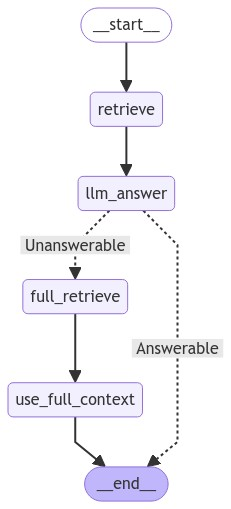

In [37]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

## LLM을 이용한 추론

In [47]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
)

results = []

for _, row in tqdm(test_df[:2].iterrows(), total=len(test_df), desc="Answering Questions"):
    initial_state = GraphState(
        question=row['Question'],
        source=normalize_string(row['Source']),
        context="",
        answer="",
        retriever=None
    )
    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        for output in app.stream(initial_state, config=config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"Output from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
    except GraphRecursionError as e:
        pprint.pprint(f"Recursion limit reached: {e}")

Answering Questions:   0%|          | 0/98 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

"Output from node 'retrieve':"
'---'
{ 'answer': '',
  'context': '## 직접 출자 출연 보조 융자 국고보조율(%) 융자율 (%) ○ ○ 3. 지출계획 총괄표 (단위: 백만원, %) '
             '|사업명|2022년 결산|2023년|Col4|2024년|증감 (B-A) (B-A)/A|Col7| '
             '|---|---|---|---|---|---|---| |||당초(A)|수정|확정(B)||(B-A)/A| '
             '|혁신창업사업화자 '
             '금(융자)|2,300,000|2,230,000|2,330,000|2,007,800|△222,200|△9.96| '
             '2023년 2024년 2022년 증감 사업명 결산 당초(A) 수정 확정(B) (B-A) (B-A)/A '
             '혁신창업사업화자 2,300,000 2,230,000 2,330,000 2,007,800 △222,200 - 9.96 '
             '금(융자)\n'
             '## 사 업 명 혁신창업사업화자금(융자) (5152-301)',
  'full_context': None,
  'question': '2022년 혁신창업사업화자금(융자)의 예산은 얼마인가요?',
  'relevance': None,
  'retriever': EnsembleRetriever(retrievers=[OktBM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7b735022f9a0>, k=5), VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b735022f940>, search_kwargs={'k': 5})]

Answering Questions:   1%|          | 1/98 [00:08<13:28,  8.33s/it]

"Output from node 'llm_answer':"
'---'
{ 'answer': '2022년 혁신창업사업화자금(융자)의 예산은 2,300,000 백만원입니다. \n\n\n',
  'context': '## 직접 출자 출연 보조 융자 국고보조율(%) 융자율 (%) ○ ○ 3. 지출계획 총괄표 (단위: 백만원, %) '
             '|사업명|2022년 결산|2023년|Col4|2024년|증감 (B-A) (B-A)/A|Col7| '
             '|---|---|---|---|---|---|---| |||당초(A)|수정|확정(B)||(B-A)/A| '
             '|혁신창업사업화자 '
             '금(융자)|2,300,000|2,230,000|2,330,000|2,007,800|△222,200|△9.96| '
             '2023년 2024년 2022년 증감 사업명 결산 당초(A) 수정 확정(B) (B-A) (B-A)/A '
             '혁신창업사업화자 2,300,000 2,230,000 2,330,000 2,007,800 △222,200 - 9.96 '
             '금(융자)\n'
             '## 사 업 명 혁신창업사업화자금(융자) (5152-301)',
  'full_context': None,
  'question': '2022년 혁신창업사업화자금(융자)의 예산은 얼마인가요?',
  'relevance': None,
  'retriever': EnsembleRetriever(retrievers=[OktBM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7b735022f9a0>, k=5), VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

"Output from node 'retrieve':"
'---'
{ 'answer': '',
  'context': '## 사 업 명 혁신창업사업화자금(융자) (5152-301)\n'
             '## 4. 사업목적 (창업기반지원) 기술력과 사업성이 우수하고 미래 성장가능성이 높은 중소벤처기업의 창업을 '
             '활성화하고 고용창출 도모 (개발기술사업화) 중소기업이 보유한 우수 기술의 사장을 방지하고 개발기술의 제품화·사업화를 '
             '촉진하여 기술기반 중소기업을 육성',
  'full_context': None,
  'question': '중소벤처기업부의 혁신창업사업화자금(융자) 사업목적은 무엇인가요?',
  'relevance': None,
  'retriever': EnsembleRetriever(retrievers=[OktBM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7b735022f9a0>, k=5), VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b735022f940>, search_kwargs={'k': 5})], weights=[0.3, 0.7]),
  'source': '중소벤처기업부_혁신창업사업화자금(융자)'}
'\n---\n'


Answering Questions:   2%|▏         | 2/98 [00:26<21:23, 13.37s/it]

"Output from node 'llm_answer':"
'---'
{ 'answer': '중소벤처기업부의 혁신창업사업화자금(융자) 사업목적은 기술력과 사업성이 우수하고 미래 성장가능성이 높은 중소벤처기업의 '
            '창업을 활성화하고 고용창출 도모 및 중소기업이 보유한 우수 기술의 사장을 방지하고 개발기술의 제품화·사업화를 촉진하여 '
            '기술기반 중소기업을 육성하는 것입니다. \n'
            '\n'
            '\n',
  'context': '## 사 업 명 혁신창업사업화자금(융자) (5152-301)\n'
             '## 4. 사업목적 (창업기반지원) 기술력과 사업성이 우수하고 미래 성장가능성이 높은 중소벤처기업의 창업을 '
             '활성화하고 고용창출 도모 (개발기술사업화) 중소기업이 보유한 우수 기술의 사장을 방지하고 개발기술의 제품화·사업화를 '
             '촉진하여 기술기반 중소기업을 육성',
  'full_context': None,
  'question': '중소벤처기업부의 혁신창업사업화자금(융자) 사업목적은 무엇인가요?',
  'relevance': None,
  'retriever': EnsembleRetriever(retrievers=[OktBM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7b735022f9a0>, k=5), VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b735022f940>, search_kwargs={'k': 5})], weights=[0.3, 0.7]),
  'source': '중소벤처기업부_혁신창업사업화자금(융자)'}
'\n---\n'


In [ ]:
# 제출용 샘플 파일 로드
base_directory = ""
submit_df = pd.read_csv(os.path.join(base_directory, "sample_submission.csv") )

# 생성된 답변을 제출 DataFrame에 추가
submit_df['Answer'] = [item['Answer'] for item in results]
submit_df['Answer'] = submit_df['Answer'].fillna("데이콘")     # 모델에서 빈 값 (NaN) 생성 시 채점에 오류가 날 수 있음 [ 주의 ]

# 결과를 CSV 파일로 저장
submit_df.to_csv(args.output_csv_file, encoding='UTF-8-sig', index=False)